**El objetivo es entrenar un clasificador de flores. Se utilizará una red neuronal pre-entrada en Imagenet y se adaptará para *clasificar* 
el dataset de input.**



In [ ]:
#Importo librerias
import torch
import torchvision
import torchsummary
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#Descargo el ZIP desde google drive
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
#Veo la cantidad de clases de flores dentro del dataset
import os 

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['sunflower', 'daisy', 'rose', 'tulip', 'dandelion']

In [ ]:
#Veo la cantidad de imagenes por clase
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: sunflower. Imágenes: 734
Categoría: daisy. Imágenes: 769
Categoría: rose. Imágenes: 784
Categoría: tulip. Imágenes: 984
Categoría: dandelion. Imágenes: 1055


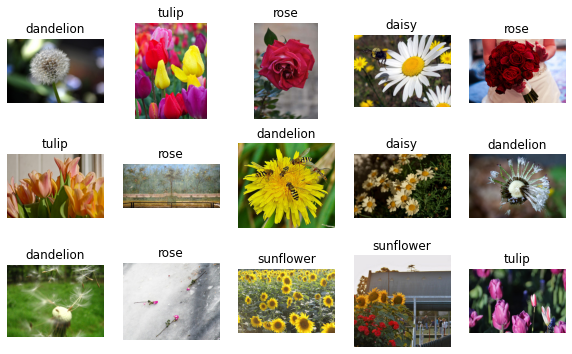

In [ ]:
#Visualizo algunas imagenes
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [ ]:
#Creo los subconjuntos de train y test
from sklearn.model_selection import train_test_split
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)
len(train_imgs), len(test_imgs)

(3458, 865)

In [ ]:
#Creo el objeto Dataset  
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargo imagen
    img = io.imread(self.X[ix])
    # aplico transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

**Agrego data augmentation**

In [ ]:

import albumentations as A
#Aplico transformaciones asegurando las dimensiones de las imagenes a 224x224

trans = A.Compose([
    A.Resize(224, 224),
    A.Blur(p=1.0),
    A.RandomBrightness(p=1.0)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])



(3458, 865)

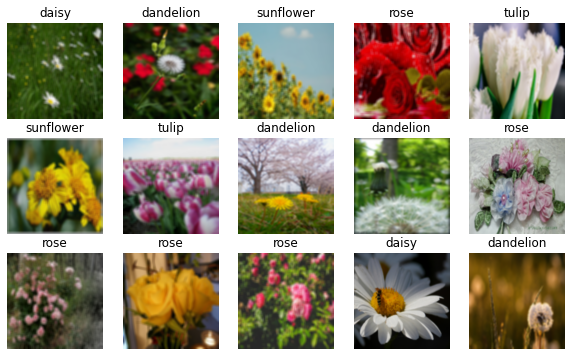

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
# Creo el objeto DataLoader
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape


torch.Size([64, 3, 224, 224])

**Carga del modelol base**

De este modelo se utilizaran todas las capas excepto la última, que va a ser sustituida por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.


In [ ]:
#MODELO BASE
resnet18_model = torchvision.models.resnet18(pretrained=True) #load resnet18 model
resnet18_model.to("cuda")

#resnet18_model= resnet18_model.to(device)
torchsummary.summary(resnet18_model, input_size=(3, 32, 32))
resnet18_model.modules

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
for param in resnet18_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = resnet18_model.fc.in_features     #extract fc layers features
resnet18_model.fc = torch.nn.Linear(num_features, 5) #(num_of_class == 5)

In [ ]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [ ]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 5])

In [ ]:
from tqdm import tqdm #terminal progress
import numpy as np
#Funcion para el entrenamiento
def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
#Entreno modelo sin transfer learning
model = Model()
fit(model, dataloader, epochs=15)

val_loss 2.22293 val_acc 0.26908: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 1/15 loss 1.35515 val_loss 2.22293 acc 0.40909 val_acc 0.26908


val_loss 3.08156 val_acc 0.28069: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 2/15 loss 1.17242 val_loss 3.08156 acc 0.52074 val_acc 0.28069


val_loss 1.55965 val_acc 0.39446: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Epoch 3/15 loss 1.08493 val_loss 1.55965 acc 0.57869 val_acc 0.39446


val_loss 1.77921 val_acc 0.42750: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Epoch 4/15 loss 1.01531 val_loss 1.77921 acc 0.60284 val_acc 0.42750


val_loss 2.98064 val_acc 0.36454: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 5/15 loss 0.97959 val_loss 2.98064 acc 0.60455 val_acc 0.36454


val_loss 2.99269 val_acc 0.30771: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 6/15 loss 0.93543 val_loss 2.99269 acc 0.63636 val_acc 0.30771


val_loss 3.05605 val_acc 0.27236: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 7/15 loss 0.92877 val_loss 3.05605 acc 0.63324 val_acc 0.27236


val_loss 4.89408 val_acc 0.27768: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 8/15 loss 0.85229 val_loss 4.89408 acc 0.68210 val_acc 0.27768


val_loss 1.74529 val_acc 0.50379: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 9/15 loss 0.81759 val_loss 1.74529 acc 0.69063 val_acc 0.50379


val_loss 14.67112 val_acc 0.19893: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 10/15 loss 0.79817 val_loss 14.67112 acc 0.69261 val_acc 0.19893


val_loss 1.20018 val_acc 0.55226: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 11/15 loss 0.81115 val_loss 1.20018 acc 0.68750 val_acc 0.55226


val_loss 3.03774 val_acc 0.36614: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Epoch 12/15 loss 0.74814 val_loss 3.03774 acc 0.71847 val_acc 0.36614


val_loss 13.17116 val_acc 0.21721: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 13/15 loss 0.77225 val_loss 13.17116 acc 0.71534 val_acc 0.21721


val_loss 3.83661 val_acc 0.38513: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 14/15 loss 0.72524 val_loss 3.83661 acc 0.71420 val_acc 0.38513


val_loss 1.53877 val_acc 0.48086: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

Epoch 15/15 loss 0.71835 val_loss 1.53877 acc 0.73011 val_acc 0.48086


Conclusion: no se obtuvieron buenos resultados durante el entrenamiento


**Entrenamiento con transfer learning**

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

val_loss 2.20119 val_acc 0.23053: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 1/5 loss 1.18220 val_loss 2.20119 acc 0.55426 val_acc 0.23053


val_loss 0.93287 val_acc 0.62917: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 2/5 loss 0.81005 val_loss 0.93287 acc 0.74460 val_acc 0.62917


val_loss 0.78391 val_acc 0.69569: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 3/5 loss 0.64486 val_loss 0.78391 acc 0.79631 val_acc 0.69569


val_loss 1.46634 val_acc 0.40227: 100%|██████████| 4/4 [00:05<00:00,  1.25s/it]


Epoch 4/5 loss 0.58013 val_loss 1.46634 acc 0.80653 val_acc 0.40227


val_loss 0.66288 val_acc 0.74061: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]

Epoch 5/5 loss 0.54724 val_loss 0.66288 acc 0.82102 val_acc 0.74061


Conclusion: Se obtuvo un mejor modelo en menos epochs y además el entrenamiento en cada epoch es mas rapido. 

**Fine Tuning**

Para mejorar un poco más se utilizarán los pesos descargados de Imagenet en resnet. Se entrena la red completa.

In [ ]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader, epochs=15)

val_loss 0.96870 val_acc 0.63139: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 1/15 loss 0.83398 val_loss 0.96870 acc 0.72727 val_acc 0.63139


val_loss 1.04429 val_acc 0.58546: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 2/15 loss 0.45907 val_loss 1.04429 acc 0.84119 val_acc 0.58546


val_loss 0.77196 val_acc 0.73893: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 3/15 loss 0.34268 val_loss 0.77196 acc 0.89062 val_acc 0.73893


val_loss 1.21414 val_acc 0.63014: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 4/15 loss 0.26237 val_loss 1.21414 acc 0.90938 val_acc 0.63014


val_loss 0.83647 val_acc 0.68538: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 5/15 loss 0.24435 val_loss 0.83647 acc 0.91250 val_acc 0.68538


val_loss 0.36817 val_acc 0.85853: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Epoch 6/15 loss 0.20907 val_loss 0.36817 acc 0.93466 val_acc 0.85853


val_loss 1.48721 val_acc 0.56488: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 7/15 loss 0.19452 val_loss 1.48721 acc 0.93750 val_acc 0.56488


val_loss 0.75303 val_acc 0.76006: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 8/15 loss 0.17550 val_loss 0.75303 acc 0.94205 val_acc 0.76006


val_loss 0.42576 val_acc 0.84442: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 9/15 loss 0.14815 val_loss 0.42576 acc 0.95653 val_acc 0.84442


val_loss 0.95994 val_acc 0.70119: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 10/15 loss 0.13458 val_loss 0.95994 acc 0.95710 val_acc 0.70119


val_loss 1.26150 val_acc 0.63112: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 11/15 loss 0.13190 val_loss 1.26150 acc 0.96193 val_acc 0.63112


val_loss 0.65761 val_acc 0.79326: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 12/15 loss 0.13986 val_loss 0.65761 acc 0.96619 val_acc 0.79326


val_loss 0.35511 val_acc 0.87274: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 13/15 loss 0.08317 val_loss 0.35511 acc 0.98210 val_acc 0.87274


val_loss 0.70121 val_acc 0.78732: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 14/15 loss 0.09222 val_loss 0.70121 acc 0.96932 val_acc 0.78732


val_loss 0.72287 val_acc 0.77330: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

Epoch 15/15 loss 0.07214 val_loss 0.72287 acc 0.97642 val_acc 0.77330


Conclusion: el modelo mejoró en comparacion con la primer corrida sin transfer learning, se obtuvo un accuracy de casi el 80%

Entreno primero el modelo sin entrenar la red pre-entrenada durante varias epochs. Luego, sigo entrenando pero actualizando los pesos en la red pre-entrenada.

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=0.0001)


val_loss 2.23440 val_acc 0.18338: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 1/5 loss 1.15467 val_loss 2.23440 acc 0.58494 val_acc 0.18338


val_loss 0.90283 val_acc 0.64037: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 2/5 loss 0.77049 val_loss 0.90283 acc 0.77244 val_acc 0.64037


val_loss 0.82808 val_acc 0.67889: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 3/5 loss 0.62539 val_loss 0.82808 acc 0.79688 val_acc 0.67889


val_loss 0.80553 val_acc 0.70198: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 4/5 loss 0.57482 val_loss 0.80553 acc 0.81335 val_acc 0.70198


val_loss 0.75843 val_acc 0.71557: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 5/5 loss 0.53989 val_loss 0.75843 acc 0.82528 val_acc 0.71557


val_loss 0.68754 val_acc 0.76014: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 1/5 loss 0.64423 val_loss 0.68754 acc 0.76506 val_acc 0.76014


val_loss 0.64208 val_acc 0.77471: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 2/5 loss 0.58463 val_loss 0.64208 acc 0.78381 val_acc 0.77471


val_loss 0.60549 val_acc 0.78181: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 3/5 loss 0.55698 val_loss 0.60549 acc 0.79688 val_acc 0.78181


val_loss 0.59237 val_acc 0.78963: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 4/5 loss 0.51705 val_loss 0.59237 acc 0.82983 val_acc 0.78963


val_loss 0.57362 val_acc 0.80970: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

Epoch 5/5 loss 0.49183 val_loss 0.57362 acc 0.83239 val_acc 0.80970


Conclusion: con menor cantidad de epocas se pudo llegar al 80% de accuracy